# Deep Learning Natural Language Processing (NLP) Project - Bag of Words Embedding in Tensorflow

# Use bag-of-words technique with a SMS database to predict text classification as spam or ham (not spam) by applying stochastic training to a three (3) hidden layer artifical neural network with logistic regression 

In [15]:
"""import numpy, tensorflow, and matplotlib.pyplot modules"""

import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
import tensorflow as tf
import matplotlib.pyplot as plt
# from tensorflow.python.framework import ops

In [16]:
""" Download or read in text data """

# Establish and initialize text data, texts, and target lists
text_data_list = []
texts_list = []
target_list = []

# Define file root location where the jupyter program file is located
data_root = '.'
save_file_name = os.path.join(data_root,'temp_spam_data.csv')
if (os.path.isfile(save_file_name)):
    print('SMS text dataset already loaded')
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        text_data_list = list(reader)
        # Remove empty lists
        text_data_list = [x for x in text_data_list if x != []]
else:
    print('Loading SMS text dataset')
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data_list = file.decode()
    text_data_list = text_data_list.encode('ascii', errors='ignore')
    text_data_list = text_data_list.decode().split('\n')
    text_data_list = [x.split('\t') for x in text_data_list if len(x)>=1]
    
    # Write text data to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts_list = [x[1] for x in text_data_list]
target_list = [x[0] for x in text_data_list]
# Relabel 'spam' as 1, 'ham' as 0
target_list = [1 if x=='spam' else 0 for x in target_list]

SMS text dataset already loaded


In [17]:
"""pre-process the text data for building the bag-of-words vocabulary"""

# Convert all letters to lower case
texts_list = [x.lower() for x in texts_list]

# Remove all punctuations
texts_list = [''.join(c for c in x if c not in string.punctuation) for x in texts_list]

# Remove all number characters
texts_list = [''.join(c for c in x if c not in '0123456789') for x in texts_list]

# Remove and time extra whitespace
texts_list = [' '.join(x.split()) for x in texts_list]

In [18]:
"""Establish bag-of-words vocabulary from pre-processed text data"""

# Declare sentence size
sentence_size = 25

# Declare minimun word frequency
min_word_freq = 3

vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)
vocab_processor.fit_transform(texts_list)

# Determine size of bag-of-word vocabulary
embedding_size = len(vocab_processor.vocabulary_)

In [19]:
"""Establish 80%/20% training and validation datasets,respectively"""

# Generate random indices from 80% of texts messages to establish the training dataset
train_indices = np.random.choice(len(texts_list), round((0.8*len(texts_list))), replace=False)

# Generate test data from the remaining text message indices
test_indices = np.array(list(set(range(len(texts_list))) - set(train_indices)))

# Generate text message training dataset list
texts_train_list = [x for ix, x in enumerate(texts_list) if ix in train_indices]

# Generate text message validation dataset list
texts_test_list = [x for ix, x in enumerate(texts_list) if ix in test_indices]

# Generate text message target classifications for training dataset list
target_train_list = [x for ix, x in enumerate(target_list) if ix in train_indices]

# Generate text message target classifications for validation dataset list
target_test_list = [x for ix, x in enumerate(target_list) if ix in test_indices]

In [20]:
"""Define functions for initializing hidden layer weights and bias variables"""

def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return (weight)

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return (bias)

In [21]:
"""Define function for fully connecting hidden layers with rectified linear unit (ReLU) activation function
    TensorFlow ML Cookbook p 172"""

def fully_connect(input_layer, weights, biases, activation):
    layer = tf.add(tf.matmul(input_layer, weights),biases)
    if (activation == True):
        # Apply ReLU activation functions only for hidden layer output
        return (tf.nn.relu(layer))
    else:
        # Sigmoid activation function applied with loss function for output layer
        return (layer)

In [22]:
"""Establish graph session variables and placeholders; and text message sentence vector """

# Declare feature data placeholder
x_data = tf.placeholder(shape = [sentence_size], dtype=tf.int32)

# Declare classification target placeholder
y_target = tf.placeholder(shape = [1,1], dtype=tf.float32)

# Establish embedding matrix for bag-of-words 

# Define identity matrix based on the number of commom words in the text messages  
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Encode text message sentence words
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)

# Generate text message sentence vector
x_col_sums = tf.reduce_sum(x_embed,0)

# Establish 2D sentence vector for model input
x_col_sums_2D = tf.expand_dims(x_col_sums,0)

In [23]:
"""Define the training model algorithm for three layer artifical neural network"""

# Define number of layer hidden nodes
layer_1_nodes = 75
layer_2_nodes = 15
layer_3_nodes = 5


# Create first layer with 75 hidden nodes
weight_1 = init_weight(shape= [embedding_size,layer_1_nodes], st_dev = 10.0)
bias_1 = init_bias(shape= [layer_1_nodes], st_dev = 10.0)
layer_1 = fully_connect(x_col_sums_2D, weight_1, bias_1, activation = True)

# Create second layer with 15 hidden nodes
weight_2 = init_weight(shape= [layer_1_nodes, layer_2_nodes], st_dev = 10.0)
bias_2 = init_bias(shape= [layer_2_nodes], st_dev = 10.0)
layer_2 = fully_connect(layer_1, weight_2, bias_2, activation = True)

# Create third layer with 5 hidden nodes
weight_3 = init_weight(shape= [layer_2_nodes, layer_3_nodes], st_dev = 10.0)
bias_3 = init_bias(shape= [layer_3_nodes], st_dev = 10.0)
layer_3 = fully_connect(layer_2, weight_3, bias_3, activation = True)

# Create output layer
weight_4 = init_weight(shape= [layer_3_nodes, 1], st_dev = 10.0)
bias_4 = init_bias(shape= [1,1], st_dev = 10.0)
model_output = fully_connect(layer_3, weight_4, bias_4, activation = False)

# Establish learning rate
learning_rate = 0.001

# Define loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = model_output))

# Define optimizer function

my_opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_step = my_opt.minimize(loss)

# Prediction Function
prediction = tf.sigmoid(model_output)

In [24]:
"""Establish graph session for stochastic training of the natural language processing (NLP)"""

# logistic regression model algorithm

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


# Define loss and training accuracy lists variables
loss_vec_list = []
train_acc_all_list = []
train_acc_avg_list = []

print('Train Model Over {} Sentences'.format(len(texts_train_list)))

# loop for graph training session
for ix, t in enumerate(vocab_processor.fit_transform(texts_train_list)):
    # Establish training target data for session placeholder
    y_data = [[target_train_list[ix]]]
    # Run stochastic graph training session
    sess.run(train_step, feed_dict = {x_data:t, y_target:y_data})
    # Run graph session to determine loss function for each generation
    temp_loss = sess.run(loss, feed_dict = {x_data:t, y_target:y_data})
    # Save generation loss value in list
    loss_vec_list.append(temp_loss)
    # Make single prediction
    [[temp_pred]] = sess.run(prediction, feed_dict = {x_data:t, y_target:y_data})
    # Determine single prediction accuracy with boolean True/False outcome
    train_acc_temp = target_train_list[ix]==np.round(temp_pred)
    train_acc_all_list.append(train_acc_temp)
    # Keeep trailing average of past 50 accuracy observations
    if (len(train_acc_all_list) >= 50):
        train_acc_avg_list.append(np.mean(train_acc_all_list[-50:]))
    # Display training outcome results from each 100 set of generation
    if ((ix+1)%100 == 0):
        print('Training Observation #{} Loss = {}'.format((ix+1), temp_loss))
        
            
# Display training accuracy results
print('Overall Training Accuracy: {}'.format(np.mean(train_acc_all_list)))

Train Model Over 4459 Sentences
Training Observation #100 Loss = 0.002105159917846322
Training Observation #200 Loss = 0.002132267924025655
Training Observation #300 Loss = 0.0021618378814309835
Training Observation #400 Loss = 0.0021852124482393265
Training Observation #500 Loss = 0.002215471351519227
Training Observation #600 Loss = 0.002237180946394801
Training Observation #700 Loss = 0.0022886241786181927
Training Observation #800 Loss = 0.0023202975280582905
Training Observation #900 Loss = 0.0023500609677284956
Training Observation #1000 Loss = 0.002392121125012636
Training Observation #1100 Loss = 0.0024131450336426497
Training Observation #1200 Loss = 0.002436785725876689
Training Observation #1300 Loss = 0.0024532966781407595
Training Observation #1400 Loss = 0.0024897318799048662
Training Observation #1500 Loss = 0.0025141218211501837
Training Observation #1600 Loss = 5.9693732261657715
Training Observation #1700 Loss = 0.0025919373147189617
Training Observation #1800 Loss = 

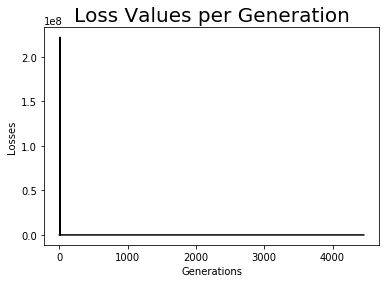

In [25]:
"""Visualize model loss values"""

#Plot Losses
plt.plot(loss_vec_list, 'k-')
plt.title('Loss Values per Generation', fontsize = 20)
plt.xlabel('Generations')
plt.ylabel('Losses')
plt.show()

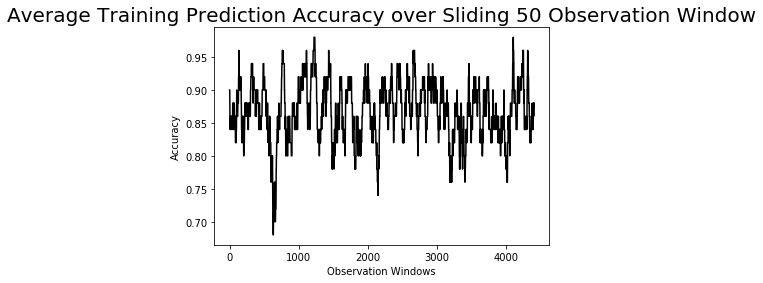

In [26]:
"""Visualize training prediction accurary"""

#Plot Losses
plt.plot(train_acc_avg_list, 'k-')
plt.title('Average Training Prediction Accuracy over Sliding 50 Observation Window', fontsize = 20)
plt.xlabel('Observation Windows')
plt.ylabel('Accuracy')
plt.show()

In [27]:
"""Establish graph session for NLP logistic regression model validation testing"""

# Define validation accuracy lists variable
test_acc_all_list = []

print('Validation Testings Over {} Sentences'.format(len(texts_test_list)))

# loop graph session for NLP logistic regression model validation testing
for ix, t in enumerate(vocab_processor.fit_transform(texts_test_list)):
    # Establish test target data for session placeholder
    y_data = [[target_test_list[ix]]]
    # Make single prediction
    [[temp_pred]] = sess.run(prediction, feed_dict = {x_data:t, y_target:y_data})
    # Determine single prediction accuracy with boolean True/False outcome
    test_acc_temp = target_test_list[ix]==np.round(temp_pred)
    test_acc_all_list.append(test_acc_temp)
  
            
# Display validation accuracy results
print('Overall Validation Accuracy: {}'.format(np.mean(test_acc_all_list)))

Validation Testings Over 1115 Sentences
Overall Validation Accuracy: 0.8591928251121076
